# Libraries

In [47]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import src.edhec_risk_kit as erk
import portfolio_design.src.analysis as an

from scipy import stats
from src import data


ix = pd.IndexSlice

%matplotlib inline

# Assets

In [257]:
asset_symbols = [
#   'VGRO.TO',
#   'ZDV.TO'
  'COST',
  'SOXX',
  'DHR',
  'COUR'
]

In [258]:
# asset_symbols_all = [
#   'STNE',
#   'SQ',
#   'PYPL',
#   'FLT',
#   'APTV',
#   'NXPI',
#   'DAN',
#   'AMD',
#   'NVDA',
#   'SJR-B.TO',
#   'IBM',
#   'MU',
#   'CUB',
#   'TCEHY',
#   'JD',
#   'T.TO',
#   'CNR.TO',
#   'DIS',
#   'CMCSA',
#   'SCR',
#   'GP',
#   'ECOM',
#   'SOXX',
#   'FISV',
#   'XPEV',
#   'LI',
#   'U',
#   'PLTR',
#   'DOC',
#   'REAL',
#   'COUR',
# ]

## Market Data

In [259]:
asset_market_data_df = (
  data
    .get_monthly_market_data(asset_symbols, interval = '1mo')
)

[*********************100%***********************]  4 of 4 completed


/Users/calvindelima/projects/investing/.venv/lib/python3.9/site-packages/pandas/core/generic.py:4152: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [260]:
asset_market_data_daily_df = (
  data
    .get_monthly_market_data(asset_symbols, interval = '1d')
)

[*********************100%***********************]  4 of 4 completed


/Users/calvindelima/projects/investing/.venv/lib/python3.9/site-packages/pandas/core/generic.py:4152: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [261]:
asset_180d_returns_df = data.compute_period_returns_from_mmd(
  asset_market_data_daily_df,
  180
)
asset_180d_returns_df.index = asset_180d_returns_df.index + pd.DateOffset(days = -180)

asset_365d_returns_df = data.compute_period_returns_from_mmd(
  asset_market_data_daily_df,
  365
)
asset_365d_returns_df.index = asset_365d_returns_df.index + pd.DateOffset(days = -365)

asset_730d_returns_df = data.compute_period_returns_from_mmd(
  asset_market_data_daily_df,
  730
)
asset_730d_returns_df.index = asset_730d_returns_df.index + pd.DateOffset(days = -730)

## Returns Data

In [262]:
# TODO: Columns insted of dataframes

asset_1mo_returns_df = data.compute_monthly_returns_from_mmd(asset_market_data_df)
asset_1mo_returns_df.index = asset_1mo_returns_df.index + pd.DateOffset(months = -1)
asset_2mo_returns_df = data.compute_monthly_returns_from_mmd(asset_market_data_df)
asset_2mo_returns_df.index = asset_2mo_returns_df.index + pd.DateOffset(months = -2)
asset_3mo_returns_df = data.compute_period_returns_from_mmd(asset_market_data_df, periods = 3)
asset_3mo_returns_df.index = asset_3mo_returns_df.index + pd.DateOffset(months = -3)
asset_6mo_returns_df = data.compute_period_returns_from_mmd(asset_market_data_df, periods = 6)
asset_6mo_returns_df.index = asset_6mo_returns_df.index + pd.DateOffset(months = -6)
asset_12mo_returns_df = data.compute_period_returns_from_mmd(asset_market_data_df, periods = 12)
asset_12mo_returns_df.index = asset_12mo_returns_df.index + pd.DateOffset(months = -12)
asset_24mo_returns_df = data.compute_period_returns_from_mmd(asset_market_data_df, periods = 24)
asset_24mo_returns_df.index = asset_24mo_returns_df.index + pd.DateOffset(months = -24)

data.compute_period_returns_from_mmd(asset_market_data_df, periods = 24)

,COST,COUR,DHR,SOXX
date,,,,
1985-01-01,NaN,NaN,NaN,NaN
1985-02-01,NaN,NaN,NaN,NaN
1985-03-01,NaN,NaN,NaN,NaN
1985-04-01,NaN,NaN,NaN,NaN
1985-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-01-01,0.716048,NaN,1.163532,1.326490
2021-02-01,0.581418,NaN,0.744966,1.328970
2021-03-01,0.520198,NaN,0.720226,1.296043


In [263]:
# (
#   r1_df
#     .melt(
#       ignore_index = False,
#       var_name = 'Asset',
#       value_name = 'Return'
#     )
#     .assign(period = '1 Month')
# )

# Prices

In [264]:
def plot_closing_prices(returns_df: pd.DataFrame):
  long_df = (
    returns_df['close']
      .reset_index()
      .assign(
        period = lambda df: df['date'].apply(
          lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
        )
      )
      .melt(
        id_vars = ['date', 'period'], 
        var_name = 'ticker', 
        value_name = 'price',
      )
  )

  sns.relplot(
    x = 'date',
    y = 'price',
    kind = 'line',
    col = 'ticker',
    hue = 'period',
    data = long_df,
    col_wrap = 4,
    facet_kws = {'sharey': False}
  );

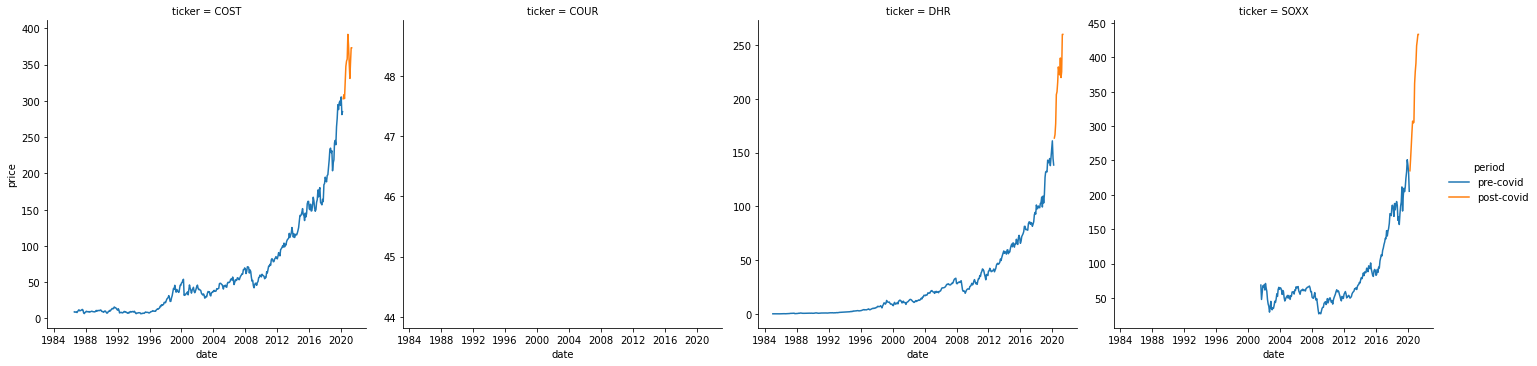

In [265]:
plot_closing_prices(asset_market_data_df)

# Return Time Series

In [266]:
def summarize_return_statistics(
  returns_df: pd.DataFrame,
  as_of: str = None):
  
  display_df = returns_df.copy()
  
  if as_of is not None:
    display_df = display_df.loc[as_of:]
  
  display(
    display_df
      .describe()
      .T
      .sort_values('mean', ascending = False)
      .assign(years = lambda df: df['count'] / 12)
      .style
      .bar(subset = ['mean', 'std'])
  )

In [267]:
def plot_returns(
  returns_df: pd.DataFrame,
  as_of: str = None):
  
  display_df = returns_df.copy()
  
  if as_of is not None:
    display_df = display_df.loc[as_of:]
    
  long_df = (
    display_df
      .reset_index()
      .assign(
        period = lambda df: df['date'].apply(
          lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
        )
      )
      .melt(id_vars = ['date', 'period'], var_name = 'ticker', value_name = 'return')
  )

  f = sns.relplot(
    x = 'date',
    y = 'return',
    kind = 'line',
    col = 'ticker',
    hue = 'period',
    data = long_df,
    col_wrap = 4
  );

  f.map(plt.axhline, y = 0, ls = '--', color = 'darkgrey');

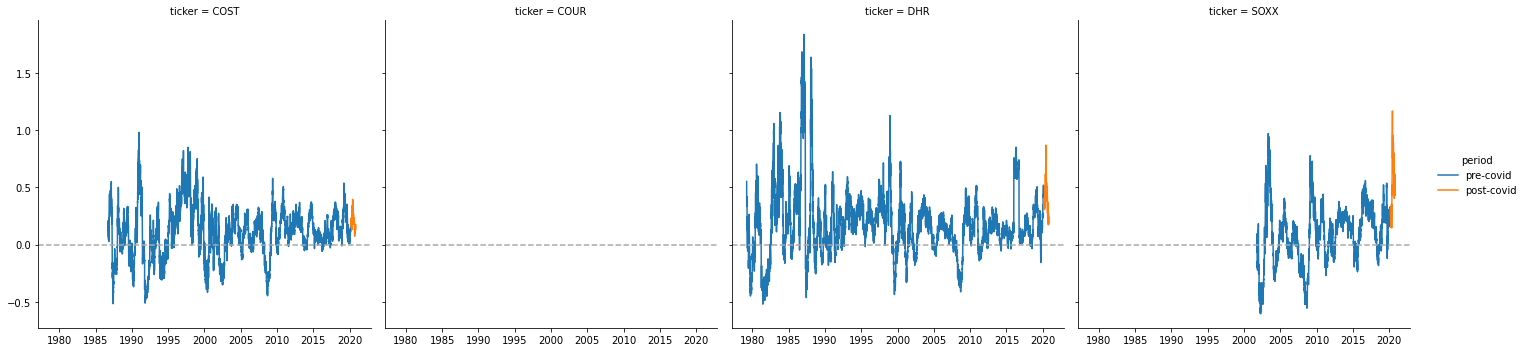

In [268]:
plot_returns(asset_180d_returns_df)

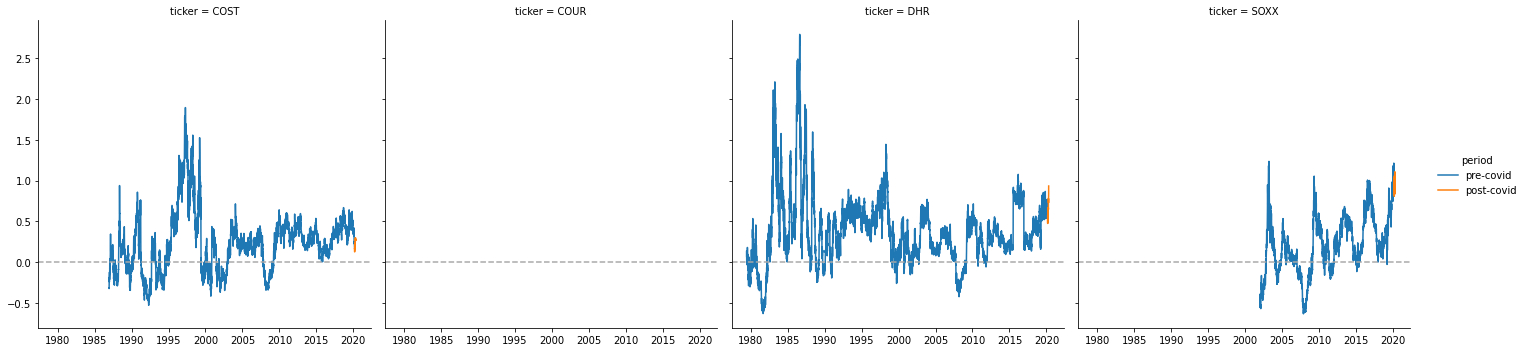

In [269]:
plot_returns(asset_365d_returns_df)

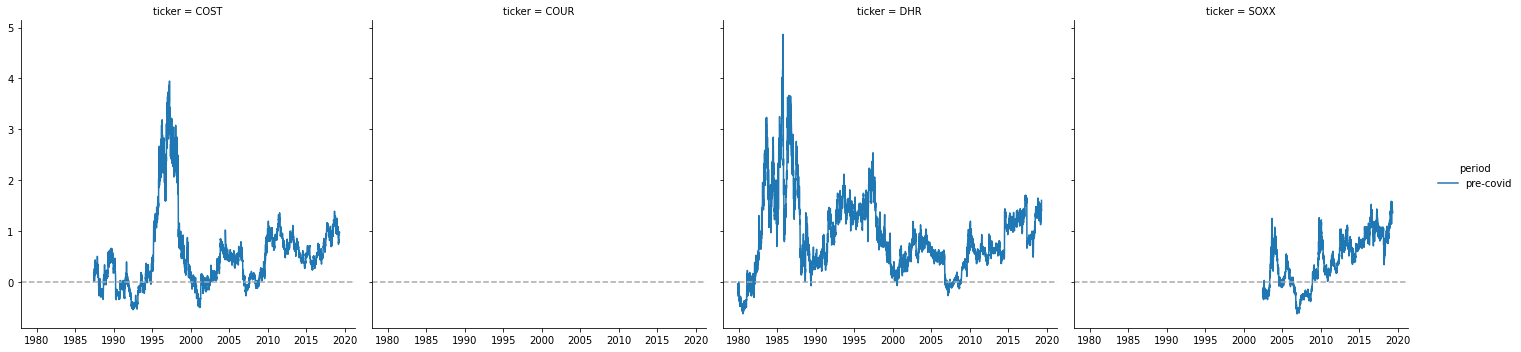

In [270]:
plot_returns(asset_730d_returns_df)

## 3 Months

In [271]:
summarize_return_statistics(asset_3mo_returns_df)

,count,mean,std,min,25%,50%,75%,max,years
DHR,434.000000,0.065325,0.154833,-0.475982,-0.014310,0.056139,0.129903,0.888888,36.166667
COST,415.000000,0.039424,0.137427,-0.460000,-0.035517,0.046624,0.119640,0.523747,34.583333
SOXX,235.000000,0.037480,0.134495,-0.448227,-0.030230,0.050283,0.118109,0.386861,19.583333
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


In [272]:
summarize_return_statistics(asset_3mo_returns_df, as_of = '2010-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,134.000000,0.064752,0.107470,-0.208232,-0.004096,0.053782,0.111434,0.600062,11.166667
SOXX,134.000000,0.059250,0.101673,-0.186489,0.009177,0.068604,0.118129,0.324511,11.166667
COST,134.000000,0.051167,0.077117,-0.132986,-0.002197,0.048834,0.109875,0.233642,11.166667
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


In [273]:
summarize_return_statistics(asset_3mo_returns_df, as_of = '2015-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,74.000000,0.080021,0.120456,-0.097188,0.000229,0.057962,0.116285,0.600062,6.166667
SOXX,74.000000,0.072492,0.104713,-0.179864,0.022622,0.074824,0.132534,0.324511,6.166667
COST,74.000000,0.047483,0.085284,-0.132986,-0.005986,0.044590,0.112259,0.233642,6.166667
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


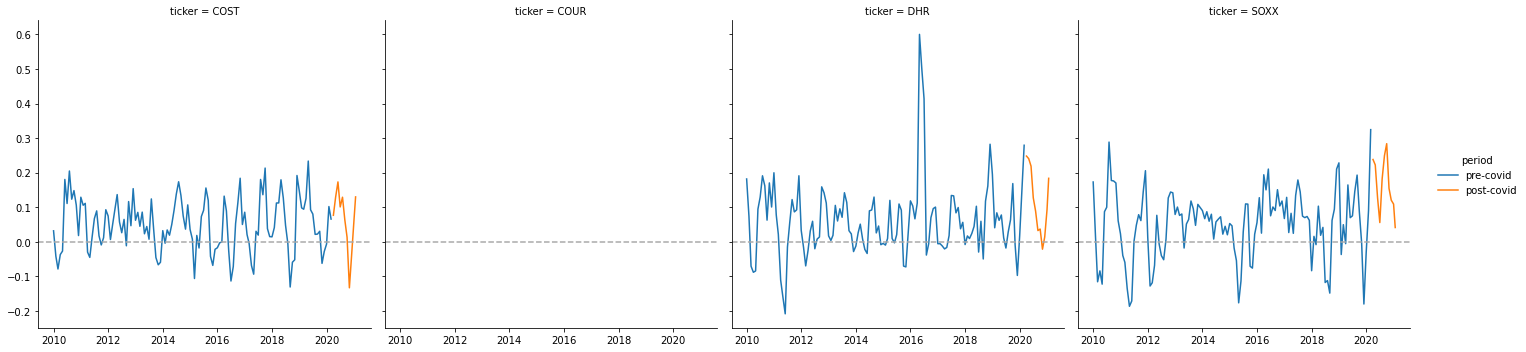

In [274]:
plot_returns(asset_3mo_returns_df, as_of = '2010-01-01')

## 12 Months

In [275]:
summarize_return_statistics(asset_12mo_returns_df)

,count,mean,std,min,25%,50%,75%,max,years
DHR,425.000000,0.264093,0.277455,-0.358158,0.099694,0.240271,0.380050,1.988230,35.416667
SOXX,226.000000,0.152641,0.308163,-0.540526,-0.047511,0.143384,0.360146,1.089520,18.833333
COST,406.000000,0.152419,0.262705,-0.515748,0.011618,0.163758,0.282418,1.059829,33.833333
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


In [276]:
summarize_return_statistics(asset_12mo_returns_df, as_of = '2010-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,125.000000,0.276133,0.202168,-0.045116,0.124272,0.215001,0.380014,0.881468,10.416667
SOXX,125.000000,0.247353,0.229147,-0.149500,0.042302,0.271113,0.398564,1.089520,10.416667
COST,125.000000,0.219927,0.114312,-0.059849,0.156598,0.224755,0.288985,0.504931,10.416667
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


In [277]:
summarize_return_statistics(asset_12mo_returns_df, as_of = '2015-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,65.000000,0.365916,0.225912,0.029169,0.180716,0.336644,0.525675,0.881468,5.416667
SOXX,65.000000,0.326845,0.253368,-0.116511,0.128385,0.379103,0.460975,1.089520,5.416667
COST,65.000000,0.205241,0.122230,-0.059849,0.134144,0.212148,0.277548,0.504931,5.416667
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


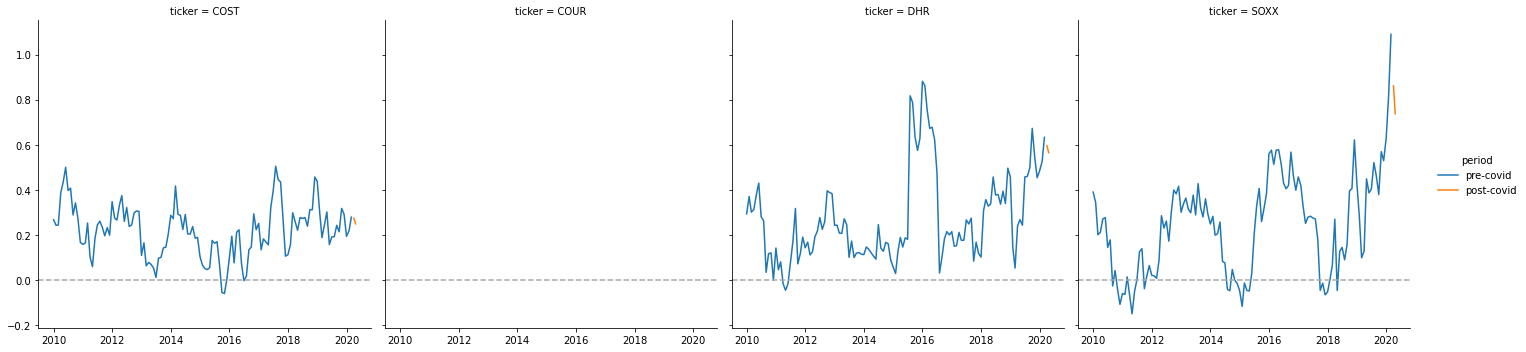

In [278]:
plot_returns(asset_12mo_returns_df, as_of = '2010-01-01')

## 24 Months

In [279]:
summarize_return_statistics(asset_24mo_returns_df)

,count,mean,std,min,25%,50%,75%,max,years
DHR,413.000000,0.579913,0.470257,-0.289743,0.288134,0.495219,0.843187,2.873423,34.416667
COST,394.000000,0.337082,0.482221,-0.472973,-0.029199,0.289932,0.512322,2.314478,32.833333
SOXX,214.000000,0.308383,0.416062,-0.566211,0.020945,0.262193,0.514755,1.517722,17.833333
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


TODO: Compare to a monthly interest rate

In [280]:
summarize_return_statistics(asset_24mo_returns_df, as_of = '2010-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,113.000000,0.592023,0.298884,0.107333,0.359161,0.511008,0.874162,1.331854,9.416667
SOXX,113.000000,0.511744,0.350825,-0.050134,0.287710,0.428908,0.691073,1.517722,9.416667
COST,113.000000,0.468606,0.169000,0.084315,0.356353,0.478758,0.569220,0.922372,9.416667
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


In [281]:
summarize_return_statistics(asset_12mo_returns_df, as_of = '2015-01-01')

,count,mean,std,min,25%,50%,75%,max,years
DHR,65.000000,0.365916,0.225912,0.029169,0.180716,0.336644,0.525675,0.881468,5.416667
SOXX,65.000000,0.326845,0.253368,-0.116511,0.128385,0.379103,0.460975,1.089520,5.416667
COST,65.000000,0.205241,0.122230,-0.059849,0.134144,0.212148,0.277548,0.504931,5.416667
COUR,0.000000,nan,nan,nan,nan,nan,nan,nan,0.000000


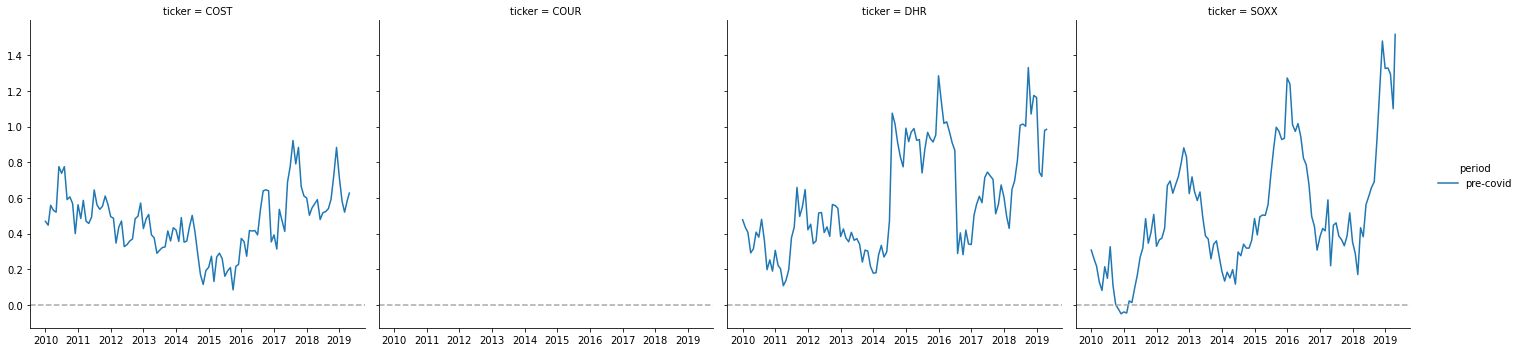

In [282]:
plot_returns(asset_24mo_returns_df, as_of = '2010-01-01')

# Correlations

In [283]:
def plot_correlation_matrix(returns_df: pd.DataFrame, as_of: str):
  display_df = returns_df.copy()
  
  if as_of is not None:
    display_df = display_df.loc[as_of:]
  
  plt.figure(figsize = (7, 5))
  sns.heatmap(display_df.corr(), annot = True)

## 3 Months

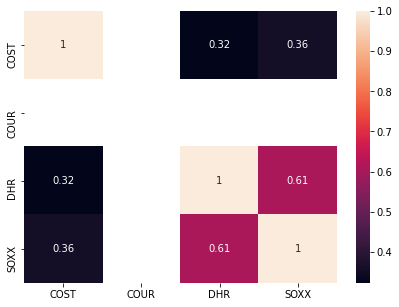

In [284]:
plot_correlation_matrix(asset_3mo_returns_df, '2010-01-01')

## 12 Months

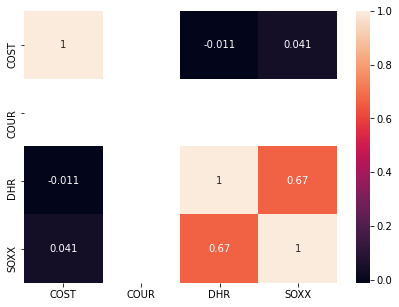

In [285]:
plot_correlation_matrix(asset_12mo_returns_df, '2010-01-01')

## 24 Months

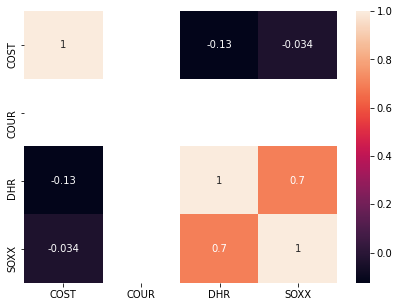

In [286]:
plot_correlation_matrix(asset_24mo_returns_df, '2010-01-01')

In [287]:
def plot_return_distributions(returns_df: pd.DataFrame, as_of: str):
  display_df = returns_df.copy()
  
  if as_of is not None:
    display_df = display_df.loc[as_of:]
    
  long_df = (
    display_df
      .reset_index()
      .assign(
        period = lambda df: df['date'].apply(
          lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
        )
      )
      .melt(id_vars = ['date', 'period'], var_name = 'ticker', value_name = 'return')
  )

  f = sns.FacetGrid(
    data = long_df,
    col = 'ticker',
    #hue = 'period',
    sharey = False,
    col_wrap = 4
  )
  
  display(long_df[~long_df.isnull()]['ticker'].value_counts())

  f.map(sns.histplot, 'return');
  f.map(plt.axvline, x=0, color = 'darkred')

# Return Distributions

## 3 Months

COST    134
DHR     134
SOXX    134
COUR    134
Name: ticker, dtype: int64

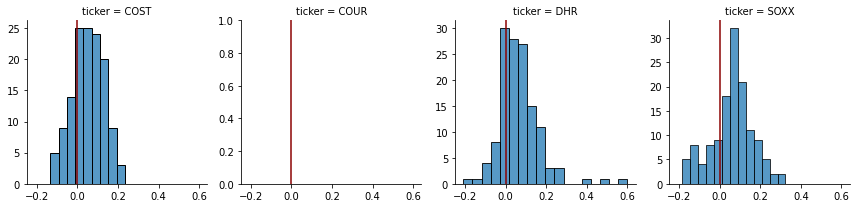

In [288]:
plot_return_distributions(asset_3mo_returns_df, '2010-01-01')

## 6 Months

COST    131
DHR     131
SOXX    131
COUR    131
Name: ticker, dtype: int64

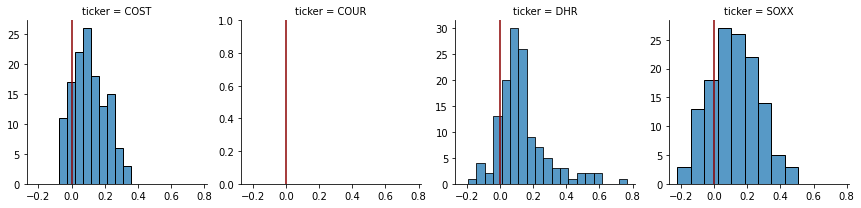

In [289]:
plot_return_distributions(asset_6mo_returns_df, '2010-01-01')

## 24 Months

COST    113
DHR     113
SOXX    113
COUR    113
Name: ticker, dtype: int64

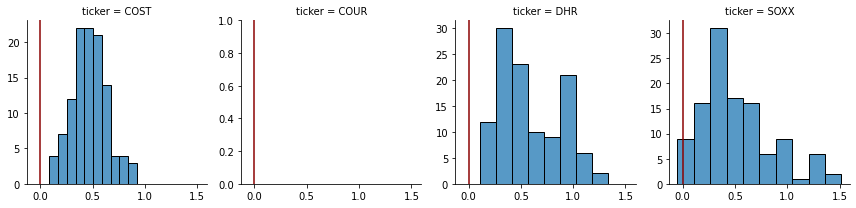

In [290]:
plot_return_distributions(asset_24mo_returns_df, '2010-01-01')

# Portfolio

In [291]:
weighted_returns_as_of = '2010-01-01'
asset_1mo_returns_period_df = asset_1mo_returns_df.loc[weighted_returns_as_of:, ]
asset_2mo_returns_period_df = asset_2mo_returns_df.loc[weighted_returns_as_of:, ]
asset_3mo_returns_period_df = asset_3mo_returns_df.loc[weighted_returns_as_of:, ]
asset_6mo_returns_period_df = asset_6mo_returns_df.loc[weighted_returns_as_of:, ]
asset_12mo_returns_period_df = asset_12mo_returns_df.loc[weighted_returns_as_of:, ]
asset_24mo_returns_period_df = asset_24mo_returns_df.loc[weighted_returns_as_of:, ]

## Time Series

Number of observations: 113


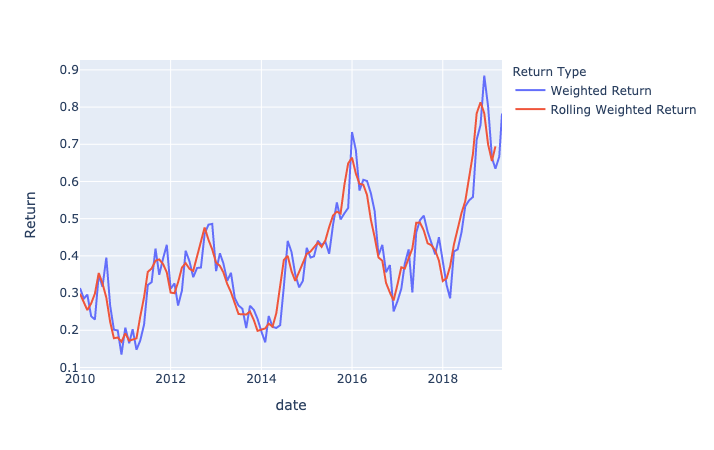

In [292]:
returns = (
  (1 / len(asset_symbols) * asset_24mo_returns_period_df)
    .sum(axis = 1)
    .rename('Weighted Return')
)
rolling_returns = (
  returns
    .rolling(3)
    .mean()
    .rename('Rolling Weighted Return')
    .shift(-2)
)
plot_df = (
  pd
    .concat([returns, rolling_returns], axis = 1)
    .reset_index()
    .melt(
      id_vars = 'date',
      value_name = 'Return',
      var_name = 'Return Type'
    )
)
print('Number of observations:', len(returns))

px.line(
  plot_df, 
  x = 'date', 
  y = 'Return', 
  color = 'Return Type'
)

We use the smoothed line to "predict" what regime we are on based on the rolling 6-year average. Probably best to pull the trigger now.

Number of observations: 134


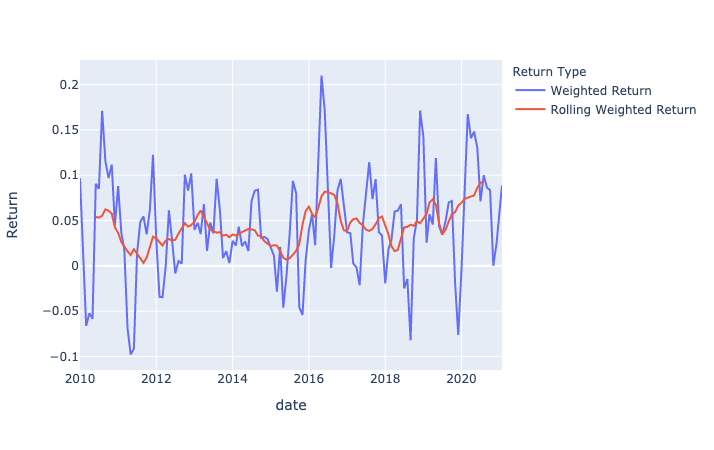

In [293]:
returns = (
  (1 / len(asset_symbols) * asset_3mo_returns_period_df)
    .sum(axis = 1)
    .rename('Weighted Return')
)
rolling_returns = (
  returns
    .rolling(12)
    .mean()
    .rename('Rolling Weighted Return')
    .shift(-6)
)
plot_df = (
  pd
    .concat([returns, rolling_returns], axis = 1)
    .reset_index()
    .melt(
      id_vars = 'date',
      value_name = 'Return',
      var_name = 'Return Type'
    )
)
print('Number of observations:', len(returns))

px.line(
  plot_df, 
  x = 'date', 
  y = 'Return', 
  color = 'Return Type'
)

## Expected Return

In [249]:
n_assets = len(asset_symbols)
equal_weights = np.repeat(1 / n_assets, n_assets)
asset_annualized_returns = erk.annualize_rets(asset_1mo_returns_period_df, periods_per_year = 24)

equal_weight_annualized_portfolio_return = erk.portfolio_return(
  equal_weights,
  asset_annualized_returns
)

r = equal_weight_annualized_portfolio_return
print('Equally Weighted Annualized Portfolio Return', round(r, 2))

Equally Weighted Annualized Portfolio Return 0.09


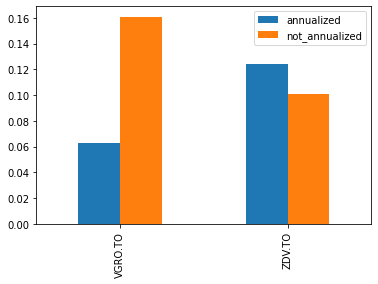

In [250]:
pd.concat([
  asset_annualized_returns.rename('annualized'),
  asset_24mo_returns_period_df.mean().rename('not_annualized')
], axis = 1).plot.bar();

So we can more or less treat annualized returns as not annualized returns.

In [251]:
asset_annualized_returns

VGRO.TO    0.063124
ZDV.TO     0.124588
dtype: float64

In [252]:
asset_24mo_returns_period_df.mean()

VGRO.TO    0.160920
ZDV.TO     0.101328
dtype: float64

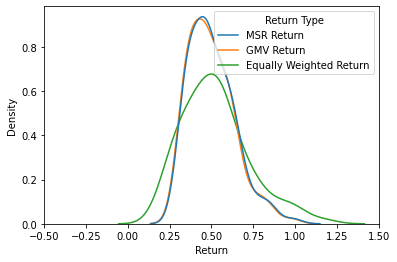

In [253]:
sns.kdeplot(data = portfolio_returns_long_df, x = 'Return', hue = 'Return Type');
plt.xlim(-0.5, 1.5);

<AxesSubplot:ylabel='Density'>

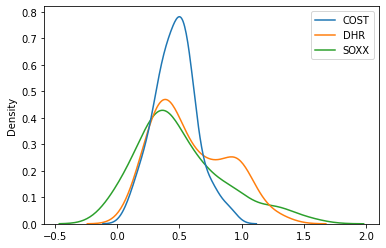

In [84]:
sns.kdeplot(data = asset_24mo_returns_period_df)

## Weights

EW Weights: [0.5 0.5]
EW Return: 0.09
MSR Weights: [0. 1.]
MSR Return: 0.12
GMV Weights: [1.00000000e+00 2.22044605e-16]
GMV Return: 0.06


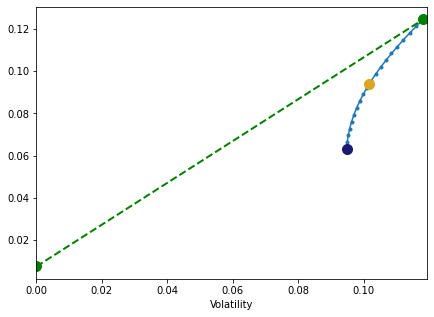

In [254]:
asset_cov = asset_24mo_returns_period_df.cov()
erk.plot_ef(
  20, 
  asset_annualized_returns, 
  asset_cov,
  show_cml = True,
  show_gmv = True,
  show_ew = True,
  riskfree_rate = 0.0075
);

## Backtest

In [43]:
                        # COST        DHR         SOXX
msr_weights = np.array([0.68449562, 0.2765573,  0.03894708])
gmv_weights = np.array([0.71874926, 0.23871065, 0.04254008])
ew_weights = equal_weights

Number of observations: 134


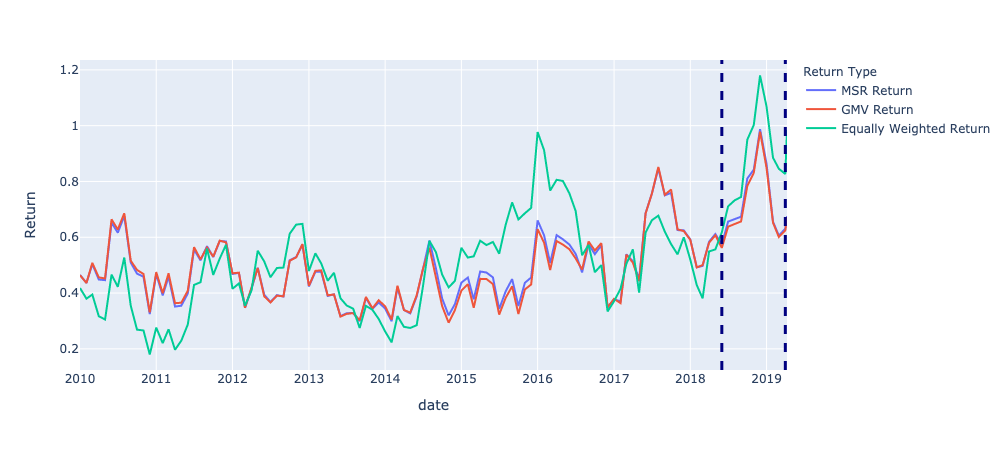

In [44]:
msr_returns = (
  (msr_weights.T * asset_24mo_returns_period_df).sum(axis = 1)
    .rename('MSR Return')
)
gmv_returns = (
  (gmv_weights.T * asset_24mo_returns_period_df).sum(axis = 1)
    .rename('GMV Return')
)
ew_returns = (
  (ew_weights.T * asset_24mo_returns_period_df).sum(axis = 1)
    .rename('Equally Weighted Return')
)
portfolio_returns_df = (
  pd
    .concat([
        msr_returns, 
        gmv_returns,
        ew_returns
      ], axis = 1
    )
)

portfolio_returns_long_df = (
  portfolio_returns_df
    .reset_index()
    .melt(
      id_vars = 'date',
      value_name = 'Return',
      var_name = 'Return Type'
    )
)

print('Number of observations:', len(returns))

f = px.line(
  portfolio_returns_long_df, 
  x = 'date', 
  y = 'Return', 
  color = 'Return Type'
)
f.add_vline(
  x='2018-06-01', 
  line_width=3, 
  line_dash="dash",
  line_color="navy")
f.add_vline(
  x='2019-04-01', 
  line_width=3, 
  line_dash="dash",
  line_color="navy")

Started a regime change in June 2018, which looks like it may be reverting back to similar returns as MSR and GMV portfolios.

In [45]:
asset_24mo_returns_period_df.apply(erk.cvar_historic)

COST   -0.142061
DHR    -0.165077
SOXX    0.023831
dtype: float64

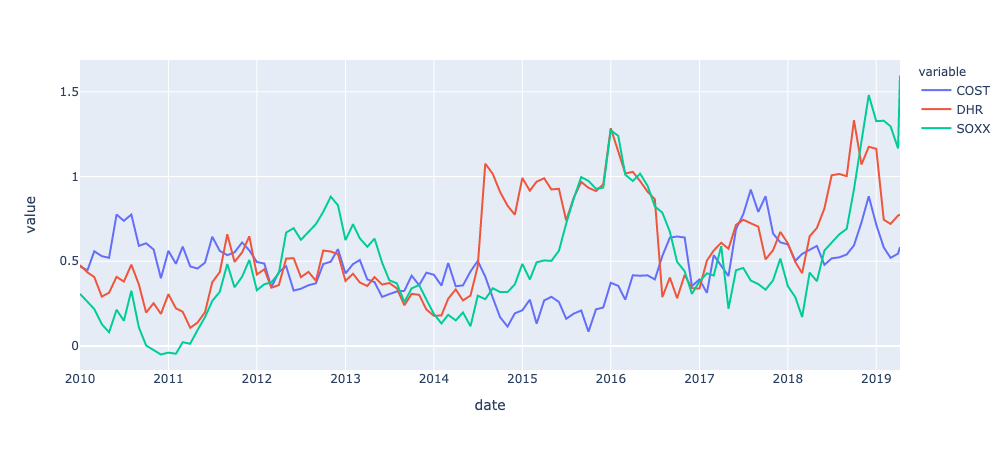

In [46]:
px.line(asset_24mo_returns_period_df)

DHR by itself has lots of upside and so does SOXX, but there is less diversity.

In [425]:
portfolio_returns_df.apply(erk.cvar_historic)

MSR Return                -0.314514
GMV Return                -0.310674
Equally Weighted Return   -0.218634
dtype: float64

In [359]:
asset_24mo_returns_period_df.apply(erk.cvar_historic)

COST   -0.142061
DHR    -0.165077
SOXX    0.023831
dtype: float64

In [360]:
portfolio_returns_df.apply(erk.cvar_historic)

MSR Return                -0.314514
GMV Return                -0.310674
Equally Weighted Return   -0.218634
dtype: float64

Equally Weighted Return    112
Name: ticker, dtype: int64

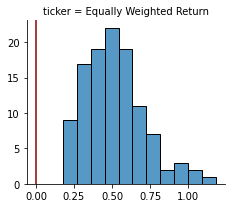

In [430]:
plot_return_distributions(portfolio_returns_df['Equally Weighted Return'], '2010-01-01')

MSR Return    135
Name: ticker, dtype: int64

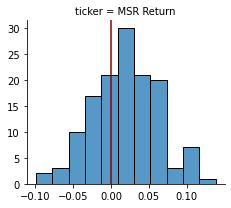

In [440]:
plot_return_distributions(
  (
    (msr_weights.T * asset_1mo_returns_period_df).sum(axis = 1)
      .rename('MSR Return')
  ),
  as_of = '2010-01-01'
)

MSR Return    124
Name: ticker, dtype: int64

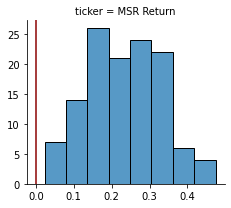

In [442]:
plot_return_distributions(
  (
    (msr_weights.T * asset_12mo_returns_period_df).sum(axis = 1)
      .rename('MSR Return')
  ),
  as_of = '2010-01-01'
)